**tmpw0h7p9s5, equation 22**

Naive ablation study on the DYAMOND data -- setting parameters to 0 and **no re-tuning**

--> The results are pretty bad/useless: Huge MSE for almost every term, removing multiple terms sometimes better than removing single terms. 

In [19]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json
import sys
import os
import gc

sys.path.insert(0, '/home/b/b309170/workspace_icon-ml/symbolic_regression')
from functions import append_dict_to_json
from sklearn import tree

# SEED = int(sys.argv[1])
SEED = 20
np.random.seed(SEED)

In [20]:
def round_expr(expr):
    d = {}
    for n in expr.atoms(sp.Number):
        d[n] = sp.Number('%.6g'%n)
    return expr.xreplace(d)

In [21]:
no_of_regimes = 2
regime = 1

**Read data**

In [22]:
all_possible_features = ['hus', 'clw', 'cli', 'ta', 'pa', 'zg', 'fr_land', 'U', 'rh', 'ps', 'hus_z', 'hus_zz', 'clw_z', 'clw_zz', 'cli_z',\
            'cli_zz', 'ta_z', 'ta_zz', 'pa_z', 'pa_zz', 'U_z', 'U_zz', 'rh_z', 'rh_zz']

loc_all = {}
for i in range(len(all_possible_features)):
    loc_all[all_possible_features[i]] = i
    
# Features
features = ['rh', 'ta', 'clw', 'cli', 'rh_z']
no_features = len(features)

loc = {}
for i in range(len(features)):
    loc[features[i]] = i

In [23]:
path_data = os.path.join('/home/b/b309170/my_work/icon-ml_data/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND')

# Load the input data and pick the five best features (rh, ta, clw, cli, rh_z)
input_data = np.load(path_data + '/cloud_cover_input_dyamond.npy')
input_data = np.concatenate([np.expand_dims(input_data[:, loc_all[sel_var]], axis=1) for sel_var in features], axis = 1)

output_data = np.load(path_data + '/cloud_area_output_dyamond.npy')

In [24]:
(samples_total, no_of_features) = input_data.shape
(samples_total, no_of_features)

(285179494, 5)

In [25]:
# Construct training and validation data
training_folds = []
validation_folds = []
two_week_incr = samples_total//6

for i in range(3):
    # Note that this is a temporal split since time was the first dimension in the original tensor
    first_incr = np.arange(samples_total//6*i, samples_total//6*(i+1))
    second_incr = np.arange(samples_total//6*(i+3), samples_total//6*(i+4))

    validation_folds.append(np.append(first_incr, second_incr))
    training_folds.append(np.arange(samples_total))
    training_folds[i] = np.delete(training_folds[i], validation_folds[i])

In [26]:
# The second fold yields the best model
flattened_input_train = input_data[training_folds[1]]
flattened_input_valid = input_data[validation_folds[1]]
flattened_output_train = output_data[training_folds[1]]
flattened_output_valid = output_data[validation_folds[1]]
    
# Remove input_data, output_data
del input_data, output_data, training_folds, validation_folds
gc.collect()

3661

In [27]:
if no_of_regimes > 1:
    # Already remove the regime with clw + cli = 0
    reg_not_0_train = np.where(flattened_input_train[:, loc['clw']] + flattened_input_train[:, loc['cli']] > 1e-20)[0]
    flattened_input_train = flattened_input_train[reg_not_0_train]
    flattened_output_train = flattened_output_train[reg_not_0_train]

    reg_not_0_valid = np.where(flattened_input_valid[:, loc['clw']] + flattened_input_valid[:, loc['cli']] > 1e-20)[0]
    flattened_input_valid = flattened_input_valid[reg_not_0_valid]
    flattened_output_valid = flattened_output_valid[reg_not_0_valid]

**Optimize coefficients in physical equation**

In [28]:
# See ~/workspace_icon-ml/symbolic_regression/finding_symmetries/pysr_results_dyamond_on_regimes/no_of_regimes_2/notes.txt
def func(X, a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,eps,A,B):
    rh = X[:, loc['rh']] 
    ta = X[:, loc['ta']] 
    clw = X[:, loc['clw']] 
    cli = X[:, loc['cli']]
    rh_z = X[:, loc['rh_z']]
    
    if np.abs(a_1) > 1e-5:
        rh = np.maximum(rh, -a_2/(2*a_1)*ta**2 + a_4/(2*a_1)*ta - a_5/(2*a_1))
    
    return a_1*rh**2+ta**2*(a_2*rh-a_3)-a_4*rh*ta+a_5*rh+a_6*ta-a_7 + (a_8*rh_z)**2*(A*rh_z+a_9) - B/(a_10*clw+a_11*cli+eps)

In [29]:
def objective(P, X,Y,force_zero=None):
    '''
        The objective function.
    '''
    a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,eps,A,B = P
    
    # A way to remove terms using a list. Somehow I cannot use locals or exec here...
    if force_zero == 'a_1': a_1 = 0
    elif force_zero == 'a_2': a_2 = 0
    elif force_zero == 'a_3': a_3 = 0
    elif force_zero == 'a_4': a_4 = 0
    elif force_zero == 'a_5': a_5 = 0
    elif force_zero == 'a_6': a_6 = 0
    elif force_zero == 'a_7': a_7 = 0
    elif force_zero == 'a_8': a_8 = 0
    elif force_zero == 'a_9': a_9 = 0
    elif force_zero == 'a_10': a_10 = 0
    elif force_zero == 'a_11': a_11 = 0
    elif force_zero == 'eps': eps = 0
    elif force_zero == 'A': A = 0
    
    elif force_zero == 'I1': (a_1, a_2, a_3, a_4, a_5, a_6, a_7) = (0,0,0,0,0,0,0)
    elif force_zero == 'I2': (a_8, a_9, A) = (0,0,0)
    elif force_zero == 'I3': B = 0
            
    train_preds = np.minimum(np.maximum(func(X, a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,eps,A,B), 0), 100) 
    train_mse = np.mean((train_preds - Y)**2, dtype=np.float64)

    return train_mse

T_subset = 10**6
inds = np.random.randint(0, flattened_input_train.shape[0], T_subset)

(a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,eps,A,B) = (203, 0.06588, 0.03969, 33.87, 4224.6, 18.9586, 2202.6, 146715, 0.00286, 8641, 32544, 0.0106, 1, 1)

**Evaluate reduced equations**

In [30]:
valid_mses = {}

In [31]:
parameters = [None,'a_1','a_2','a_3','a_4','a_5','a_6','a_7','a_8','a_9','a_10','a_11','A','I1','I2','I3']

for par_ind in range(len(parameters)):
    force_zero = parameters[par_ind]

    valid_reg_mse = objective((a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,eps,A,B), flattened_input_train[inds], flattened_output_train[inds], force_zero)

    # Compute full valid mse
    mse_reg_0 = 0.0353
    n_0 = 32419018
    n_21 = 62640812
    N = n_0 + n_21

    print('On the entire dataset')
    print('Valid MSE: %.5f'%((n_0*mse_reg_0 + n_21*valid_reg_mse)/N))

    # Add to dictionary
    if force_zero == None:
        valid_mses['full_eq'] = ((n_0*mse_reg_0 + n_21*valid_reg_mse)/N)
    else:      
        valid_mses[force_zero] = ((n_0*mse_reg_0 + n_21*valid_reg_mse)/N)

On the entire dataset
Valid MSE: 104.69478
On the entire dataset
Valid MSE: 3551.95483
On the entire dataset
Valid MSE: 3722.89120
On the entire dataset
Valid MSE: 1368.06447
On the entire dataset
Valid MSE: 1368.09748
On the entire dataset
Valid MSE: 3722.89120
On the entire dataset
Valid MSE: 3722.89120
On the entire dataset
Valid MSE: 1368.05199
On the entire dataset
Valid MSE: 136.27977
On the entire dataset
Valid MSE: 165.52182
On the entire dataset
Valid MSE: 1576.26594
On the entire dataset
Valid MSE: 1343.01572
On the entire dataset
Valid MSE: 113.44076
On the entire dataset
Valid MSE: 3593.58931
On the entire dataset
Valid MSE: 136.27977
On the entire dataset
Valid MSE: 368.16814


In [37]:
with open('/home/b/b309170/workspace_icon-ml/symbolic_regression/finding_symmetries/pysr_results_dyamond_on_regimes/no_of_regimes_2/ablation_study/naive_ablation_study_phys_seed_%d.json'%SEED, 'w') as file:
    json.dump(valid_mses, file)

**Plot results**

In [38]:
with open('/home/b/b309170/workspace_icon-ml/symbolic_regression/finding_symmetries/pysr_results_dyamond_on_regimes/no_of_regimes_2/ablation_study/naive_ablation_study_phys_seed_%d.json'%SEED, 'r') as file:
    valid_mses = json.load(file)

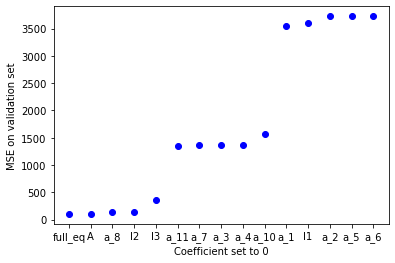

In [39]:
sorted_inds = np.argsort(list(valid_mses.values()))
plt.plot(np.delete(np.array(list(valid_mses.keys()))[sorted_inds], 4), np.delete(np.array(list(valid_mses.values()))[sorted_inds], 4), 'bo')
plt.ylabel('MSE on validation set')
plt.xlabel('Coefficient set to 0')
plt.savefig('/home/b/b309170/workspace_icon-ml/symbolic_regression/finding_symmetries/pysr_results_dyamond_on_regimes/no_of_regimes_2/ablation_study/naive_ablation_study_phys_seed_%d.pdf'%SEED)

Text(0.5, 0, 'Coefficient set to 0')

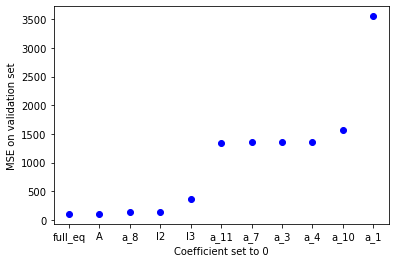

In [35]:
sorted_inds = np.argsort(list(valid_mses.values()))
plt.plot(np.delete(np.array(list(valid_mses.keys()))[sorted_inds], 4)[:-4], np.delete(np.array(list(valid_mses.values()))[sorted_inds], 4)[:-4], 'bo')
plt.ylabel('MSE on validation set')
plt.xlabel('Coefficient set to 0')